In [2]:
!pip install h2o
import pandas as pd
import matplotlib.pyplot as plt

import h2o
h2o.init()

     |████████████████████████████████| 164.6MB 95kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.3-py2.py3-none-any.whl size=164649662 sha256=a0a79dbca9978fc89579fa5b72d3fe115d6eef0d54c75608fbe85ccdd22922ee
  Stored in directory: /root/.cache/pip/wheels/0a/fd/63/96d322a27867a81a2904172a75aed5241913d603a4b8c4b277
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprof7erwn
  JVM stdout: /tmp/tmprof7erwn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprof7erwn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connectin

H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_gdwvwu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
df = pd.read_csv(
  '/content/data_stroke.csv')
data = h2o.import_file('/content/data_stroke.csv')
data['Surv'] = data['Surv'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
data.describe()

Rows:113
Cols:9




,Gender,Age,AF,Localisation,AMI_Unst.ang,GFR,Surv,Q_non_Q,DM
type,enum,int,enum,enum,enum,int,enum,enum,enum
mins,,56.0,,,,9.0,,,
mean,,77.01769911504424,,,,43.00000000000002,,,
maxs,,98.0,,,,98.0,,,
sigma,,8.869069749984408,,,,20.34128454997022,,,
zeros,,0,,,,0,,,
missing,0,0,0,0,0,0,0,59,0
0,male,56.0,No_AF,Left_car,AMI,14.0,death,non_Q,Diabetes
1,male,59.0,No_AF,Left_car,Unst_ang,98.0,alive,,No_Diabetes
2,female,86.0,AF,Left_car,AMI,57.0,death,non_Q,Diabetes


In [5]:
data['Surv'].table()

Surv,Count
alive,52
death,61


In [6]:
data['Gender'].table()

Gender,Count
female,83
male,30


In [7]:
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator

In [8]:
# Set predictors and response variable
response = "Surv"
predictors = data.col_names.remove(response)


In [9]:
# split
train, test = data.split_frame(seed = 1234, 
                                  ratios = [0.75], 
                                  destination_frames = ["train.hex", "test.hex"])

In [10]:
train.col_names

['Gender',
 'Age',
 'AF',
 'Localisation',
 'AMI_Unst.ang',
 'GFR',
 'Surv',
 'Q_non_Q',
 'DM']

In [11]:
stroke_xgb = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=1234)

In [12]:
stroke_xgb.train(x=predictors,
                  y=response,
                  training_frame=train,
                  validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [32]:
stroke_xgb.accuracy()

[[0.6939302682876587, 1.0]]

In [34]:
stroke_xgb.confusion_matrix(valid=test)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38981395959854126: 


,,alive,death,Error,Rate
0,alive,10.0,4.0,0.2857,(4.0/14.0)
1,death,0.0,15.0,0.0,(0.0/15.0)
2,Total,10.0,19.0,0.1379,(4.0/29.0)


In [14]:
stroke_xgb.auc(valid=test)

0.838095238095238

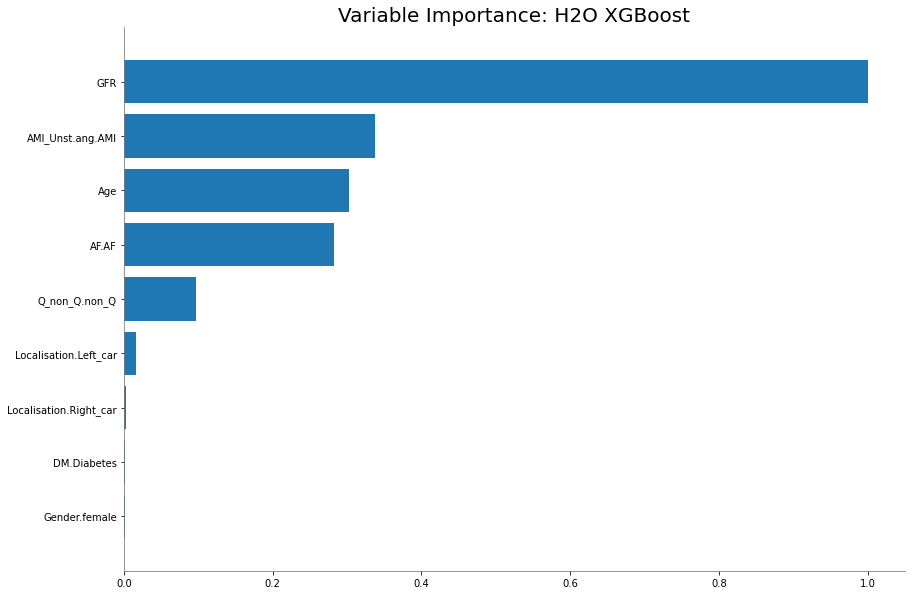

In [15]:
stroke_xgb.varimp_plot()

In [16]:
aml = H2OAutoML(max_models = 6, max_runtime_secs = 120, seed = 12345)
aml.train(x = predictors, y = response, training_frame = train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [18]:
lb = aml.leaderboard

In [19]:
lb.head(rows=5)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_20210116_112545,0.866667,0.460474,0.840542,0.142857,0.362449,0.131369
StackedEnsemble_BestOfFamily_AutoML_20210116_112545,0.842857,0.446959,0.704081,0.107143,0.354997,0.126023
StackedEnsemble_AllModels_AutoML_20210116_112545,0.838095,0.455212,0.700163,0.107143,0.370997,0.137639
XGBoost_3_AutoML_20210116_112545,0.828571,0.508935,0.811584,0.178571,0.405357,0.164314
DRF_1_AutoML_20210116_112545,0.82381,0.551078,0.738875,0.17619,0.406136,0.164946


In [20]:
aml.varimp_heatmap


<bound method varimp_heatmap of <h2o.automl.autoh2o.H2OAutoML object at 0x7f55300566d8>>

In [21]:
import scipy
from scipy import stats
x = df[df['Surv'] == 'death']['GFR']
y = df[df['Surv'] == 'alive']['GFR']


In [22]:
y

1      98
3      69
5      86
7      52
10     47
14     21
15     46
20     21
23     75
25     66
26     27
27     41
30     38
32     70
34     48
35     55
40     29
41     90
42     29
43     54
46     84
47     54
53     40
54     78
56     98
59     86
60     52
66     21
69     75
71     66
72     27
73     38
76     48
77     55
79     29
80     90
81     29
84     84
85     54
91     72
92     51
94     40
95     45
97     47
98     60
99     44
101    43
102    46
106    31
110    33
111    46
112    25
Name: GFR, dtype: int64

In [23]:
x.name, y.name = 'death', 'alive'

In [26]:
res = stats.ttest_ind(x, y)
print('p-value: ', res[1])

p-value:  4.6154989422980537e-07


In [27]:
from h2o.estimators.coxph import H2OCoxProportionalHazardsEstimator

In [28]:
data.col_names

['Gender',
 'Age',
 'AF',
 'Localisation',
 'AMI_Unst.ang',
 'GFR',
 'Surv',
 'Q_non_Q',
 'DM']

In [29]:
stroke_coxph = H2OCoxProportionalHazardsEstimator(
                                                 stop_column="GFR",
                                                 ties="breslow")
stroke_coxph.train(x=predictors,
            y=response,
            training_frame=train)

/usr/local/lib/python3.6/dist-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [Q_non_Q]
  warnings.warn(mesg["message"], RuntimeWarning)


coxph Model Build progress: |█████████████████████████████████████████████| 100%


In [30]:

pred = stroke_coxph.predict(test)

coxph prediction progress: |██████████████████████████████████████████████| 100%


In [31]:
stroke_coxph.coefficients_table

Model Details
H2OCoxProportionalHazardsEstimator :  Cox Proportional Hazards
Model Key:  CoxPH_model_python_1610796178099_704

Call: 
Surv(GFR, Surv) ~ Gender + Age + AF + Localisation + AMI_Unst.ang + DM

Coefficients: CoxPH Coefficients


,names,coefficients,exp_coef,exp_neg_coef,se_coef,z_coef
0,Localisation.Right_car,0.447030,1.563661,0.639525,0.362632,1.232737
1,Localisation.Vertebro_bas,0.135233,1.144804,0.873512,0.508271,0.266066
2,AF.No_AF,-0.504044,0.604083,1.655402,0.339281,-1.485625
3,Gender.male,-0.367024,0.692793,1.443433,0.432585,-0.848444
4,AMI_Unst.ang.Unst_ang,-1.922897,0.146183,6.840749,0.746244,-2.576766
5,DM.No_Diabetes,-0.798111,0.450179,2.221341,0.345460,-2.310285
6,Age,-0.003384,0.996622,1.003389,0.022620,-0.149588



Likelihood ratio test=26.501240
n=84, number of events=46

Scoring History: 


,,timestamp,duration,iterations,loglik
0,,2021-01-16 11:27:08,0.000 sec,0,-178.081986
1,,2021-01-16 11:27:08,0.003 sec,1,-166.081022
2,,2021-01-16 11:27:08,0.005 sec,2,-164.892873
3,,2021-01-16 11:27:08,0.007 sec,3,-164.831951
4,,2021-01-16 11:27:08,0.008 sec,4,-164.831366
5,,2021-01-16 11:27:08,0.010 sec,5,-164.831366


<bound method H2OCoxPHModel.coefficients_table of >